# (15) HRF -- Cosine sim

**Motivation**: Quantify HRF results using cosine similarity. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


muted = sns.color_palette('muted', n_colors=10)
colors = [muted[0], muted[9], muted[1], muted[8]]


def _fix(k: str):
    k = k.replace('preproc\n', '')
    if 'hrf' in k:
        k = k.split('\n')[-1]
        k = f"{k} (HRF)"
    return k


def _do(pi, pi_indiv, n_resamples: int = int(1e4)):
    sim, sim_overall = cosine_sim(pi_indiv)
    sim_b, sim_overall_b = cosine_sim_boot(
        pi, n_resamples=n_resamples)
    test = sim_perm(pi, n_resamples=n_resamples * 10)
    test = {
        k: d for k, d
        in test.items()
        if isinstance(d, dict)
    }

    # put results as dict
    test_fixed = {}
    for k, d in test.items():
        d_fixed = {}
        for a, b in d.items():
            if isinstance(b, np.ndarray):
                k1, k2 = a
                d_fixed[(_fix(k1), _fix(k2))] = b
            else:
                (k1, k2), (k3, k4) = a
                d_fixed[(
                    (_fix(k1), _fix(k2)),
                    (_fix(k3), _fix(k4)),
                )] = b
        test_fixed[k] = d_fixed
    test = test_fixed
    
    results = {
        'sim': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim.items()},
        'sim_b': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim_b.items()},
    }
    results_overall = {7: {
        'sim_overall': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim_overall.items()},
        'sim_overall_b': {(_fix(k1), _fix(k2)): v for (k1, k2), v in sim_overall_b.items()},
    }}
    return results, results_overall, test


def default_props_anesth(
        num_k: int = 7,
        perc: int = 15,
        **kwargs, ):
    mice = Mice(512)
    props_base = {
        'mice': mice,
        'num_k': num_k,
        'task': 'rest',
        'perc': f'p{perc}-sample',
        'metric': 'pearson',
        'sv_props': {
            'match_using': 'gam',
            'match_metric': 'euclidean'},
        'graph_type': 'real',
        'kw_kmeans': {'n_init': 100},
        'verbose': False,
    }
    kwargs = setup_kwargs(props_base, kwargs)
    props_ca = {'mode': 'ca2', **kwargs}
    return mice, props_ca

## Mice

In [3]:
mice, props = default_props_anesth()
kws_show = show_kws(props['num_k'])
bs = Base(mice, mode='ca2')

translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}
kws_fig = dict(bbox_inches='tight', dpi=300, transparent=True)
fig_dir = pjoin(fig_base_dir, 'rebuttal', 'hrf_cos')
print(fig_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal/memberships

## HRF (load)

In [4]:
pi = np.load(
    pjoin(tmp_dir, 'pi_run.npy'),
    allow_pickle=True,
).item()

# fix ordering (bring BOLD to front)
order = list(pi)
item = next(e for e in order if 'BOLD' in e)
order.pop(order.index(item))
order = [item] + order
pi = {k: pi.get(k) for k in order}

# compute individual & group results
pi_indiv = {
    k: avg(v, ndim_start=1)
    for k, v in pi.items()
}
pi_grp = {
    k: avg(v) for k, v
    in pi_indiv.items()
}

In [5]:
"fig, axes = bs.show(pi_grp, **kws_show)"

'fig, axes = bs.show(pi_grp, **kws_show)'

## Cos. Sim. Boot

In [6]:
%%time

n_resamples = int(1e4)

results, results_overall, test = _do(
    pi, pi_indiv, n_resamples=n_resamples)

CPU times: user 14min 24s, sys: 2min 4s, total: 16min 29s
Wall time: 16min 30s


In [7]:
# get relevant subset
order = [
    (BOLD, CAS),
    (BOLD, f"{CAS} (HRF)"),
    (BOLD, CAF),
    (BOLD, f"{CAF} (HRF)"),
]
results_subset = {
    k: {t: d.get(t) for t in order}
    for k, d in results.items()
}
results_overall_subset = {7: {
    k: {t: d.get(t) for t in order}
    for k, d in results_overall[7].items()
}}

# replace with GABAN
cossim_gaban = np.load(
    pjoin(tmp_dir, 'cossim_gaban.npy'),
    allow_pickle=True,
).item()

results_final = {
    k: {
        a: cossim_gaban[k][a]
        if a in cossim_gaban[k]
        else b for a, b in d.items()
    } for k, d in results_subset.items()
}
results_overall_final = {7: {
    k: {
        a: cossim_gaban[k][a]
        if a in cossim_gaban[k]
        else b for a, b in d.items()
    } for k, d in results_overall_subset[7].items()
}}

## Plot

In [31]:
from figures.fig_ocs import similarity_point

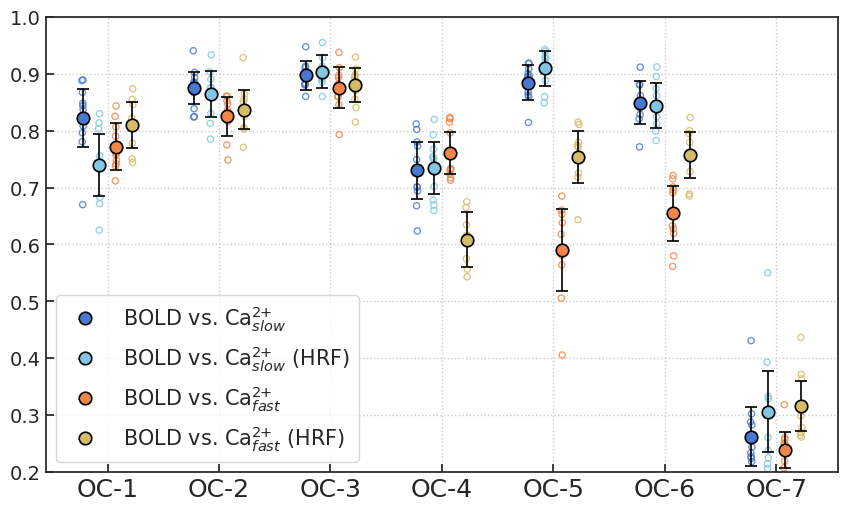

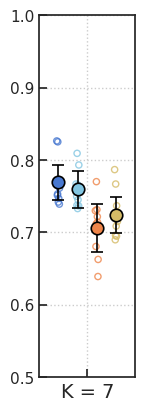

In [62]:
# sim
fig, ax = similarity_point(
    results=results_final,
    overall=False,
    legend_fontsize=15,
    tick_labelsize_x=18,
    tick_labelsize_y=14,
    figsize=(9, 5),
    aspect=12,
    width=0.3,
    display=False,
    colors=colors,
)
fig.savefig(pjoin(fig_dir, 'cos_sim_hrf.pdf'), **kws_fig)
display(fig)

# sim overall
width = 0.15
fig, ax = similarity_point(
    results=results_overall_final,
    overall=True,
    figsize=(5, 4),
    width=width,
    aspect=7.5,
    # pad=0.1,
    display=False,
    legend=False,
    colors=colors,
)
a, b = ax.get_xlim()
ax.set_xlim(a - width, b + width)

fig.savefig(pjoin(fig_dir, 'cos_sim_overall_hrf.pdf'), **kws_fig)
display(fig)

In [27]:
a = results_overall_final[7]['sim_overall'][order[0]].mean()
b = results_overall_final[7]['sim_overall'][order[1]].mean()

a, b, a - b

(0.7690675705434064, 0.7593358443845606, 0.009731726158845766)

In [17]:
selected_tests = [
    (order[0], order[1]),
    (order[2], order[3]),
]

In [19]:
{k: test['tests_overall'].get(k) for k in selected_tests}

{
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)')): PermutationTestResult(
        statistic=0.026849572699059944,
        pvalue=1.999980000199998e-05,
        null_distribution=array([-0.00518333, -0.00318876,  0.00426955, ...,  0.00496341,
        0.00796733, -0.00531785])
    ),
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')): PermutationTestResult(
        statistic=-0.02021792908347129,
        pvalue=0.00013999860001399987,
        null_distribution=array([ 0.00513024,  0.00011509,  0.00619777, ...,  0.00842169,
       -0.00653297,  0.00056685])
    )
}

In [18]:
{k: v.pvalue for k, v in test['tests_overall'].items() if k in selected_tests}

{
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)')): 1.999980000199998e-05,
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')): 0.00013999860001399987
}

In [12]:
{k: v.pvalue for k, v in test['tests'].items()}

{
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')): array([2.47737523e-01, 6.79993200e-04, 1.99998000e-05, 1.99998000e-05,
       1.99998000e-05, 1.99998000e-05, 3.47996520e-03]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)')): array([1.99998000e-05, 2.23997760e-03, 1.99998000e-05, 1.31798682e-02,
       2.82277177e-01, 8.00991990e-02, 3.28756712e-01]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')): array([7.54592454e-02, 6.09613904e-01, 9.73390266e-01, 1.99998000e-05,
       1.99998000e-05, 1.99998000e-05, 1.99998000e-05]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'), ('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')): array([1.99998e-05, 1.99998e-05, 1.99998e-05, 1.99998e-05, 1.99998e-05,
       1.99998e-05, 1.99998e-05]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)')): array([1.99998000e-05, 7.52072479e-01, 6.86073139e-01, 1.99998000e-05,
       1.99998000e-05, 1.99998000e-05, 7.57992420e-03]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')): array([6.97213028e-01, 4.99995000e-04, 1.99998000e-05, 1.99998000e-05,
       1.99998000e-05, 8.69991300e-03, 1.99998000e-05]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'), ('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')): array([1.99998e-05, 1.99998e-05, 1.99998e-05, 1.99998e-05, 1.99998e-05,
       1.99998e-05, 1.99998e-05]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)'), ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')): array([1.99998000e-05, 2.81797182e-02, 1.59998400e-04, 1.99998000e-05,
       1.99998000e-05, 5.17994820e-03, 1.79998200e-04]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)'), ('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')): array([1.99998e-05, 1.99998e-05, 1.99998e-05, 1.99998e-05, 1.99998e-05,
       1.99998e-05, 1.99998e-05]),
    (('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)'), ('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')): array([1.9999800e-05, 1.9999800e-05, 1.9999800e-05, 1.9999800e-05,
       8.9595104e-01, 1.9999800e-05, 1.9999800e-05])
}

In [13]:
p = [1.99998000e-05, 2.23997760e-03, 1.99998000e-05, 1.31798682e-02,
     2.82277177e-01, 8.00991990e-02, 3.28756712e-01]

In [14]:
reject, *_ = multipletests(pvals=p, method='fdr_bh', alpha=0.05)

In [15]:
reject

array([ True,  True,  True,  True, False, False, False])

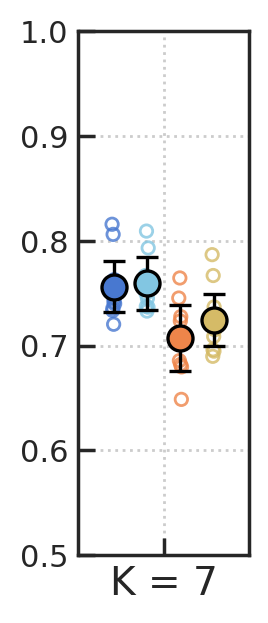

In [28]:
width = 0.3

fig, ax = similarity_point(
    results=results_overall_subset,
    overall=True,
    figsize=(4, 3),
    width=width,
    # pad=0.1,
    dpi=200,
    display=False,
    legend=False,
    colors=colors,
)
a, b = ax.get_xlim()
ax.set_xlim(a - width, b + width)

display(fig)

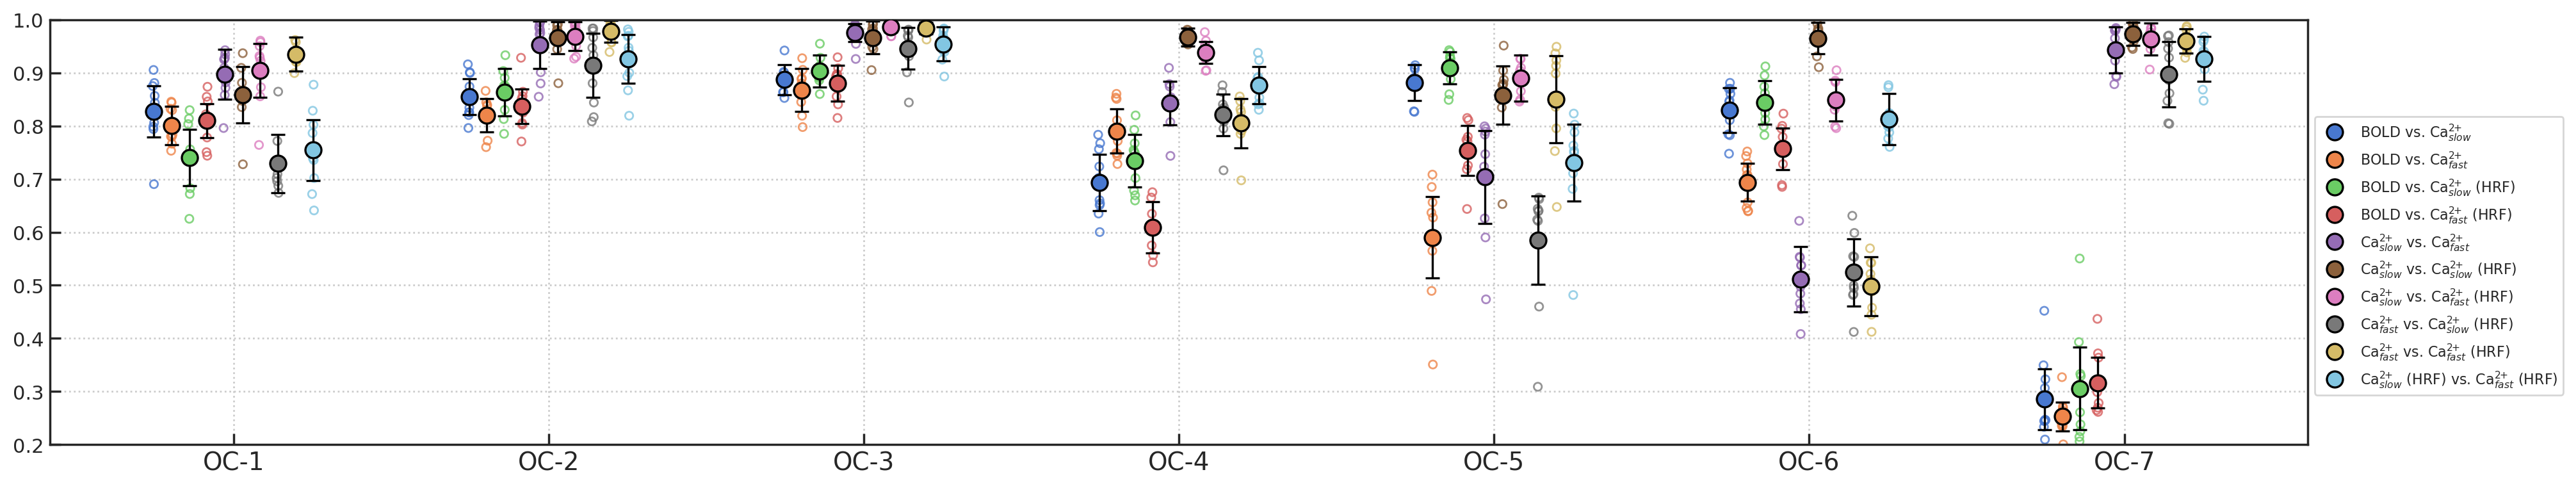

In [9]:
fig, ax = similarity_point(
    results=results,
    overall=False,
    legend_fontsize=8,
    figsize=(20, 12),
    dpi=200,
    display=False,
    delta=2,
)
move_legend(ax, (1.0, 0.1))

display(fig)

In [10]:
muted = sns.color_palette('muted', n_colors=10)
colors = [muted[0], muted[9], muted[1], muted[8]]

muted

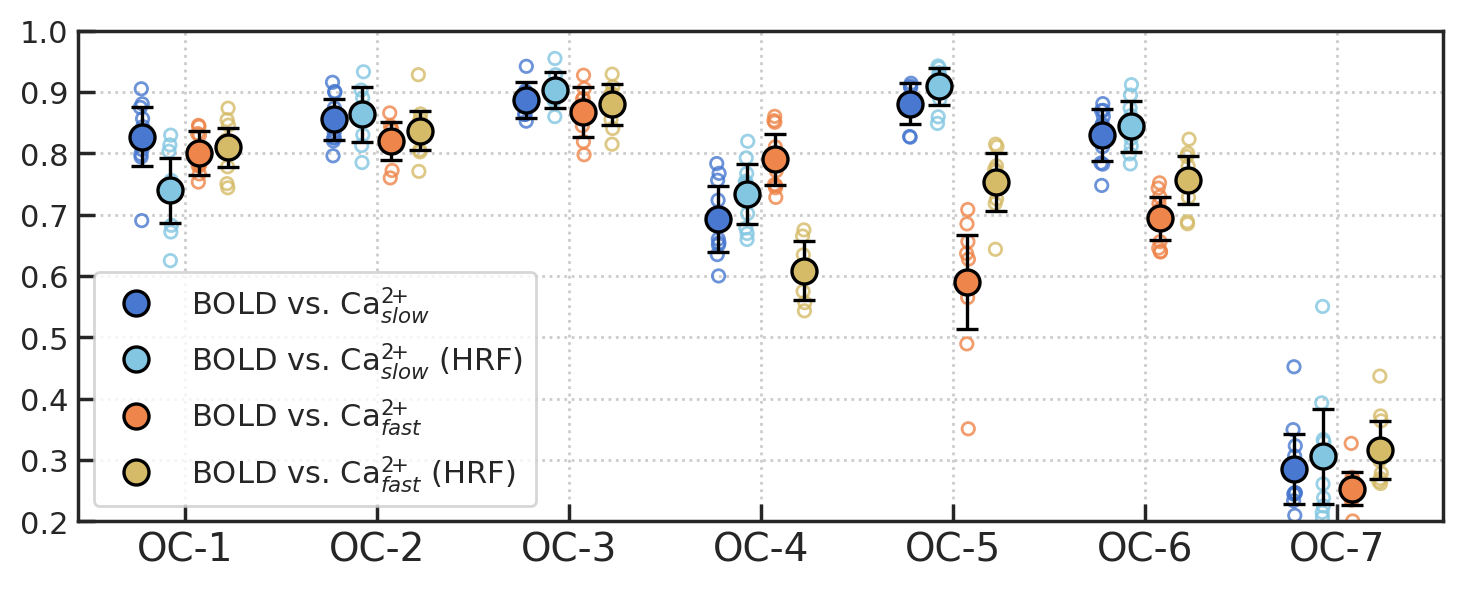

In [11]:
fig, ax = similarity_point(
    results=results_subset,
    overall=False,
    legend_fontsize=11,
    # figsize=(7, 6),
    width=0.3,
    dpi=200,
    display=False,
    colors=colors,
)
# move_legend(ax, (1.0, 0.1))
display(fig)

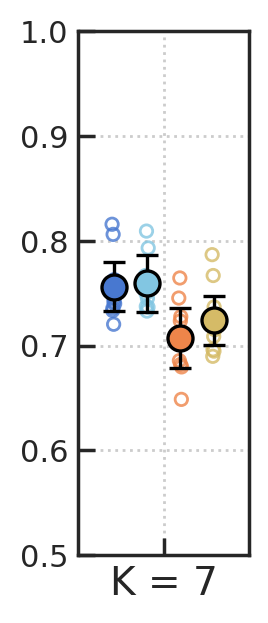

In [12]:
width = 0.3

fig, ax = similarity_point(
    results=results_overall_subset,
    overall=True,
    figsize=(4, 3),
    width=width,
    # pad=0.1,
    dpi=200,
    display=False,
    legend=False,
    colors=colors,
)
a, b = ax.get_xlim()
ax.set_xlim(a - width, b + width)

display(fig)

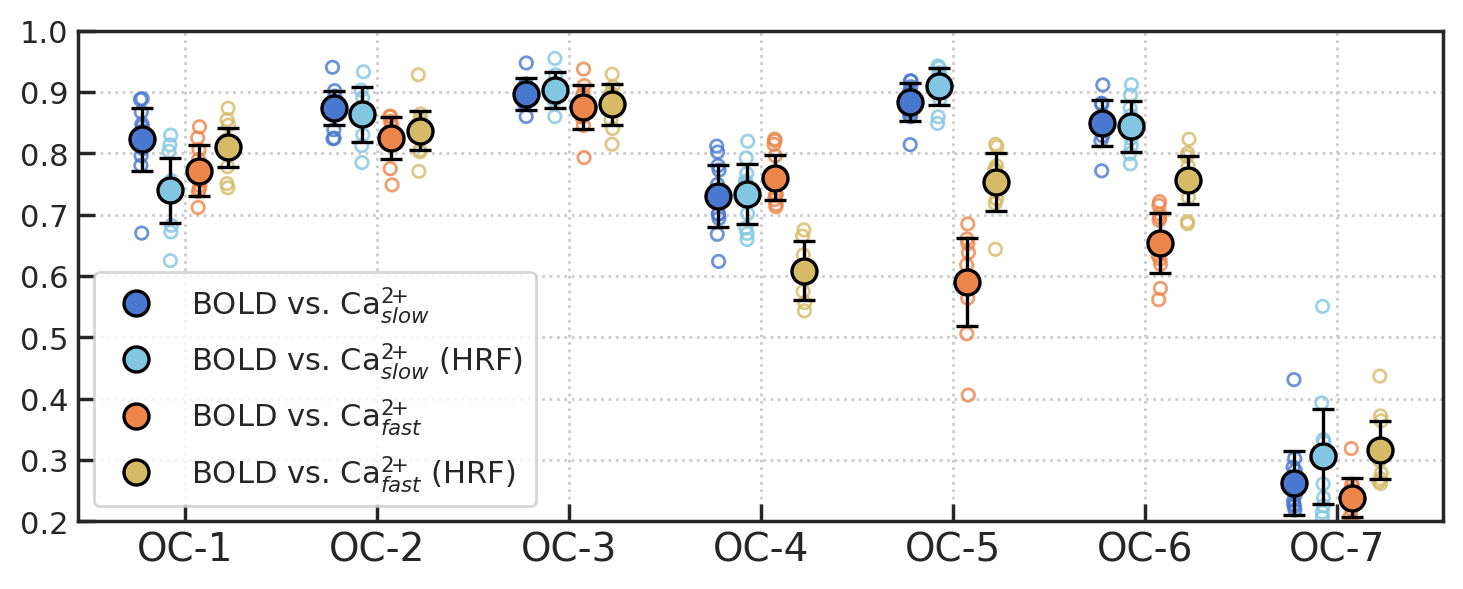

In [15]:
list(test)

['sim_run', 'sim_run_overall', 'tests', 'tests_overall']

<Axes: ylabel='Count'>

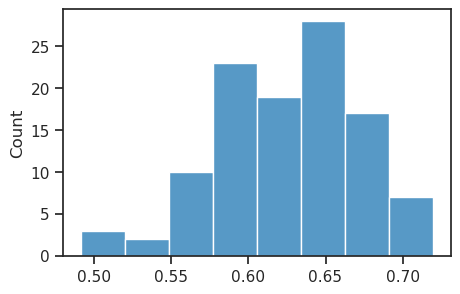

In [16]:
sns.histplot(list(test['sim_run_overall'].values())[0])

In [19]:
for k, v in test['tests'].items():
    k

In [20]:
k

(
    ('preproc\nBOLD', 'hrf\nCa$^{2\\!\\!+}_{fast}$'),
    ('preproc\nCa$^{2\\!\\!+}_{slow}$', 'preproc\nCa$^{2\\!\\!+}_{fast}$')
)

In [22]:
v.pvalue

array([0.001998 , 0.001998 , 0.001998 , 0.001998 , 0.9030969, 0.001998 ,
       0.001998 ])

In [12]:
scores, std_err = _scores_arr({'sim': sim, 'sim_b': sim_b}, False)
scores.shape, std_err.shape

((10, 7, 10), (7, 10))

In [13]:
scores.mean(0)

array([[0.82754119, 0.80069361, 0.73995803, 0.81004651, 0.89739839,
        0.85826196, 0.90430754, 0.72900771, 0.93459611, 0.75442066],
       [0.855398  , 0.8204722 , 0.86372438, 0.83707782, 0.95275321,
        0.96565129, 0.96870963, 0.91417117, 0.97779531, 0.92661047],
       [0.88704908, 0.86738749, 0.90314371, 0.88009062, 0.97582344,
        0.9662941 , 0.9865879 , 0.94547551, 0.98386155, 0.95429581],
       [0.69331461, 0.79020451, 0.73442612, 0.60866193, 0.84337081,
        0.96751111, 0.93780139, 0.82068464, 0.80538402, 0.87656796],
       [0.88110241, 0.59010914, 0.90942319, 0.75374494, 0.70370309,
        0.85798681, 0.88994169, 0.58507391, 0.85005145, 0.73054359],
       [0.8300165 , 0.69386648, 0.84404121, 0.75706194, 0.51127594,
        0.96512005, 0.84839666, 0.52408054, 0.49798542, 0.81286783],
       [0.28562278, 0.25281166, 0.30575994, 0.31646346, 0.94265406,
        0.97324084, 0.96357109, 0.89753748, 0.95984619, 0.92575569]])

## Cos. sim. print

### Overall

In [7]:
for (k1, k2), v in sim_overall.items():
    boot = sp_stats.bootstrap(
        data=(v,),
        statistic=np.mean,
        n_resamples=1e4,
        method='BCa',
        random_state=0,
    )
    er95 = boot.standard_error * get_tval(ci=0.95)
    sim = f"{v.mean():0.3f} " + r"$\pm$" + f" {er95:0.3f}"
    
    c1 = k1.replace('\\!\\!', '').replace('preproc', '')
    c2 = k2.replace('\\!\\!', '').replace('preproc', '')
    msg = ','.join([
        f"{c1} $\,\,$ vs. $\,\,$ {c2} ",
        f"$\quad$ cos sim = {sim}",
    ])
    display(Latex(msg))